# Lab 12 - MNIST Autoencoder

## Description:
Familiarize yourself with MxNet by following the official Python tutorials of MxNet In the next lab. Concretely, you should go through the following tutorials:

[A 60-minute Gluon crash course](https://mxnet.apache.org/api/python/docs/tutorials/getting-started/crash-course/index.html)

[PyTorch to MXNet (MNIST)](https://mxnet.apache.org/api/python/docs/tutorials/getting-started/to-mxnet/pytorch.html)

Your assignment is to:

- Convert the MNIST classifier (from the crash course) to an MNIST autoencoder (vanilla, not variational)
- Train it
- Test it 
- Reconstruct some images
- Sample some images

### Authors:
Nolan Cardozo, Chris Beem, Ajinkya Indulkar

In [1]:
# import libraries
import time
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

# mxnet framework
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn
import mxnet.ndarray as F

%matplotlib inline
# Fixing the random seed
mx.random.seed(42)

Set Device Mode

In [2]:
def gpu_exists():
    try:
        mx.nd.zeros((1,), ctx=mx.gpu(0))
    except:
        return False
    return True

data_ctx = mx.cpu()
if gpu_exists():
    print('Using GPU for model_ctx')
    model_ctx = mx.gpu(0)
else:
    print('Using CPU for model_ctx')
    model_ctx = mx.cpu()

Using CPU for model_ctx


### Load Dataset

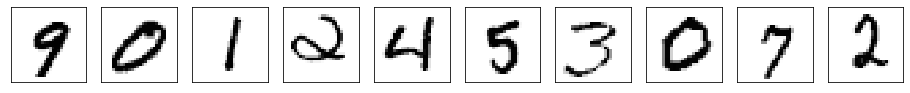

In [3]:
# Fixing the random seed
mx.random.seed(42)

# Gettin the mnist dataset
mnist = mx.test_utils.get_mnist()

n_samples = 10
idx = np.random.choice(len(mnist['train_data']), n_samples)
_, axarr = plt.subplots(1, n_samples, figsize=(16,4))
for i,j in enumerate(idx):
    axarr[i].imshow(mnist['train_data'][j][0], cmap='Greys')
    #axarr[i].axis('off')
    axarr[i].get_xaxis().set_ticks([])
    axarr[i].get_yaxis().set_ticks([])
plt.show()

In [4]:
#setting batch size
batch_size = 100
# creating training and validation set
train_data = mx.io.NDArrayIter(mnist['train_data'], mnist['train_label'], batch_size, shuffle=True)
val_data = mx.io.NDArrayIter(mnist['test_data'], mnist['test_label'], batch_size)

##  Dense Autoencoder
### Create Model

In [5]:
class Autoencoder(gluon.Block):
    def __init__(self, input_size = 28*28, latent = 10, **kwargs):
        super(Autoencoder, self).__init__(**kwargs)
        with self.name_scope():
            self.encoder = nn.Sequential() 
            self.encoder.add(nn.Dense(512, activation='relu'))
            self.encoder.add(nn.Dense(128, activation='relu'))
            self.encoder.add(nn.Dense(latent, activation=None))
        
            self.decoder = nn.Sequential()
            self.decoder.add(nn.Dense(128, activation='relu'))
            self.decoder.add(nn.Dense(512, activation='relu'))
            self.decoder.add(nn.Dense( input_size, activation='sigmoid'))
    
    def forward(self, x):
        self.output = self.decoder(self.encoder(x))
        return self.output

In [6]:
# call the model
net = Autoencoder()
# initalise network weights
net.collect_params().initialize(mx.init.Xavier(), ctx=model_ctx)

In [7]:
# define loss criterion
mse_loss = gluon.loss.L2Loss()
# set optimization algorithm and learning rate
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': 0.001})

### Train Model

In [8]:
n_epoch = 50
start = time.time()
training_loss = []
validation_loss = []
for epoch in tqdm(range(n_epoch), desc='epochs'):
    epoch_loss = 0
    epoch_val_loss = 0
    
    # refresh datasets
    train_data.reset()
    val_data.reset()
    
    # iterate over train data
    n_batch_train = 0
    for tbatch in train_data:
        n_batch_train +=1
        data = tbatch.data[0].as_in_context(model_ctx)
        with autograd.record():
            y = net(data)
            tloss = mse_loss(y,data)
        # backprop
        tloss.backward()
        trainer.step(data.shape[0])
        epoch_loss += nd.mean(tloss).asscalar()
    
    # iterate over validation data
    n_batch_val = 0
    for batch in val_data:
        n_batch_val +=1
        vdata = batch.data[0].as_in_context(model_ctx)
        vy = net(vdata)
        vloss = mse_loss(vy,vdata)
        epoch_val_loss += nd.mean(vloss).asscalar()
    
    # update training history
    epoch_loss /= n_batch_train
    epoch_val_loss /= n_batch_val

    training_loss.append(epoch_loss)
    validation_loss.append(epoch_val_loss)


    tqdm.write('Epoch{}, Training loss {:.4f}, Validation loss {:.4f}'.format(epoch, epoch_loss, epoch_val_loss))

end = time.time()
print('Time elapsed: {:.2f}s'.format(end - start))

Epoch0, Training loss 0.0173, Validation loss 0.0104
Epoch1, Training loss 0.0096, Validation loss 0.0089
Epoch2, Training loss 0.0085, Validation loss 0.0081
Epoch3, Training loss 0.0079, Validation loss 0.0076
Epoch4, Training loss 0.0075, Validation loss 0.0074
Epoch5, Training loss 0.0072, Validation loss 0.0072
Epoch6, Training loss 0.0070, Validation loss 0.0070
Epoch7, Training loss 0.0067, Validation loss 0.0068
Epoch8, Training loss 0.0066, Validation loss 0.0067
Epoch9, Training loss 0.0064, Validation loss 0.0066
Epoch10, Training loss 0.0063, Validation loss 0.0065
Epoch11, Training loss 0.0062, Validation loss 0.0064
Epoch12, Training loss 0.0061, Validation loss 0.0064
Epoch13, Training loss 0.0060, Validation loss 0.0063
Epoch14, Training loss 0.0059, Validation loss 0.0063
Epoch15, Training loss 0.0058, Validation loss 0.0062
Epoch16, Training loss 0.0058, Validation loss 0.0062
Epoch17, Training loss 0.0057, Validation loss 0.0062
Epoch18, Training loss 0.0056, Validat

### View Results

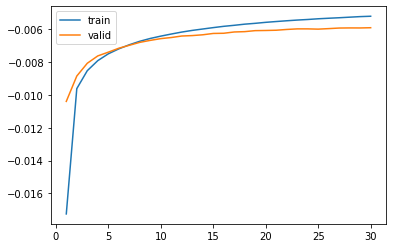

In [10]:
# plot training
batch_x = np.linspace(1, n_epoch, len(training_loss))
plt.plot(batch_x, -1*np.array(training_loss))
plt.plot(batch_x, -1*np.array(validation_loss))
plt.legend(['train', 'valid'])
plt.show()

### Save Model

In [9]:
model_prefix = "model_dense"
net.save_parameters(model_prefix)

### Test and Recontruct Images

In [11]:
net2 = Autoencoder()
net2.load_parameters(model_prefix, ctx=model_ctx)

In [12]:
val_data.reset()
test_batch = val_data.next()
net2(test_batch.data[0].as_in_context(model_ctx))
result = net2.output.asnumpy()
original = test_batch.data[0].asnumpy()

#### Visualize Reconstructed Images

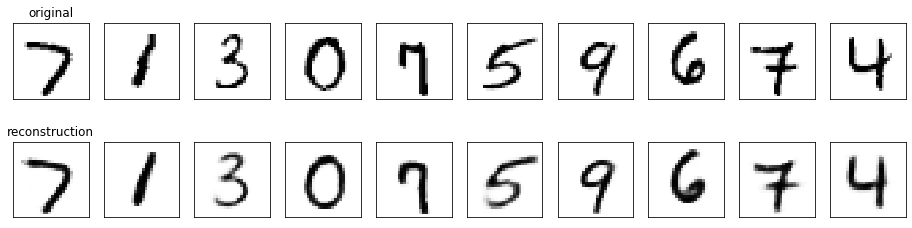

In [13]:
n_samples = 10
idx = np.random.choice(batch_size, n_samples)
_, axarr = plt.subplots(2, n_samples, figsize=(16,4))
for i,j in enumerate(idx):
    axarr[0,i].imshow(original[j].reshape((28,28)), cmap='Greys')
    if i==0:
        axarr[0,i].set_title('original')
    #axarr[0,i].axis('off')
    axarr[0,i].get_xaxis().set_ticks([])
    axarr[0,i].get_yaxis().set_ticks([])

    axarr[1,i].imshow(result[j].reshape((28,28)), cmap='Greys')
    if i==0:
        axarr[1,i].set_title('reconstruction')
    #axarr[1,i].axis('off')
    axarr[1,i].get_xaxis().set_ticks([])
    axarr[1,i].get_yaxis().set_ticks([])
plt.show()

#### Sample random images from the latent space

In [14]:
n_samples = 10
zsamples = nd.array(np.random.randn(n_samples*n_samples, 10))

In [15]:
images = net2.decoder(zsamples.as_in_context(model_ctx)).asnumpy()

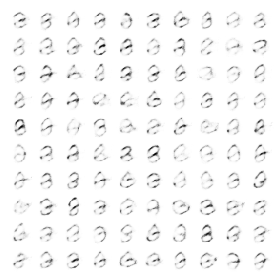

In [16]:
canvas = np.empty((28*n_samples, 28*n_samples))
for i, img in enumerate(images):
    x = i // n_samples
    y = i % n_samples
    canvas[(n_samples-y-1)*28:(n_samples-y)*28, x*28:(x+1)*28] = img.reshape(28, 28)
plt.figure(figsize=(4, 4))
plt.imshow(canvas, origin="upper", cmap="Greys")
plt.axis('off')
plt.tight_layout()

## Convolutional Autoencoder
### Create Model

In [17]:
class Convolutional_Autoencoder(gluon.Block):
    def __init__(self, **kwargs):
        super(Convolutional_Autoencoder, self).__init__(**kwargs)
        with self.name_scope():
            self.encoder = nn.Sequential() 
            self.encoder.add(nn.Conv2D(channels = 16,kernel_size = 3,strides= 3,padding = 1, activation='relu'))
            self.encoder.add(nn.MaxPool2D(pool_size = 2, strides = 2))
            self.encoder.add(nn.Conv2D(channels = 8,kernel_size = 3,strides= 2,padding = 1, activation='relu'))
            self.encoder.add(nn.MaxPool2D(pool_size = 2, strides = 1))
        
            self.decoder = nn.Sequential()
            self.decoder.add(nn.Conv2DTranspose(channels = 16,kernel_size = 3, strides=2, activation='relu'))
            self.decoder.add(nn.Conv2DTranspose(channels = 8,kernel_size = 5, strides=3, padding=1,activation = 'relu'))
            self.decoder.add(nn.Conv2DTranspose(channels = 1,kernel_size = 2, strides=2, padding=1,activation = 'tanh'))
    
    def forward(self, x):
        self.output = self.decoder(self.encoder(x))
        return self.output

In [18]:
# call the model
conv_net = Convolutional_Autoencoder()
# initalise network weights
conv_net.collect_params().initialize(mx.init.Xavier(), ctx=model_ctx)

In [19]:
# define loss criterion
mse_loss = gluon.loss.L2Loss()
# set optimization algorithm and learning rate
trainer = gluon.Trainer(conv_net.collect_params(), 'adam', {'learning_rate': 0.001})

### Train Model

In [20]:
n_epoch = 100

start = time.time()
training_loss = []
validation_loss = []
for epoch in tqdm_notebook(range(n_epoch), desc='epochs'):
    epoch_loss = 0
    epoch_val_loss = 0

    train_data.reset()
    val_data.reset()

    n_batch_train = 0
    for tbatch in train_data:
        n_batch_train +=1
        data = tbatch.data[0].as_in_context(model_ctx)
        with autograd.record():
            y = conv_net(data)
            tloss = mse_loss(y,data)
        tloss.backward()
        trainer.step(data.shape[0])
        epoch_loss += nd.mean(tloss).asscalar()

    n_batch_val = 0
    for batch in val_data:
        n_batch_val +=1
        vdata = batch.data[0].as_in_context(model_ctx)
        vy = conv_net(vdata)
        vloss = mse_loss(vy,vdata)
        epoch_val_loss += nd.mean(vloss).asscalar()

    epoch_loss /= n_batch_train
    epoch_val_loss /= n_batch_val

    training_loss.append(epoch_loss)
    validation_loss.append(epoch_val_loss)


    tqdm.write('Epoch{}, Training loss {:.4f}, Validation loss {:.4f}'.format(epoch, epoch_loss, epoch_val_loss))

end = time.time()
print('Time elapsed: {:.2f}s'.format(end - start))

Epoch0, Training loss 0.0275, Validation loss 0.0209
Epoch1, Training loss 0.0193, Validation loss 0.0177
Epoch2, Training loss 0.0172, Validation loss 0.0164
Epoch3, Training loss 0.0162, Validation loss 0.0155
Epoch4, Training loss 0.0156, Validation loss 0.0150
Epoch5, Training loss 0.0151, Validation loss 0.0146
Epoch6, Training loss 0.0147, Validation loss 0.0143
Epoch7, Training loss 0.0144, Validation loss 0.0139
Epoch8, Training loss 0.0142, Validation loss 0.0137
Epoch9, Training loss 0.0140, Validation loss 0.0137
Epoch10, Training loss 0.0138, Validation loss 0.0135
Epoch11, Training loss 0.0137, Validation loss 0.0133
Epoch12, Training loss 0.0136, Validation loss 0.0132
Epoch13, Training loss 0.0135, Validation loss 0.0131
Epoch14, Training loss 0.0134, Validation loss 0.0131
Epoch15, Training loss 0.0133, Validation loss 0.0130
Epoch16, Training loss 0.0133, Validation loss 0.0130
Epoch17, Training loss 0.0132, Validation loss 0.0129
Epoch18, Training loss 0.0132, Validat

### View Results

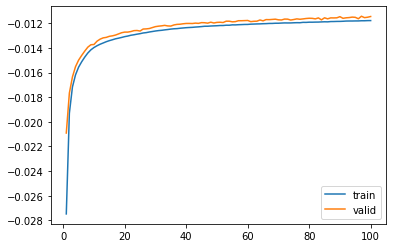

In [22]:
batch_x = np.linspace(1, n_epoch, len(training_loss))
plt.plot(batch_x, -1*np.array(training_loss))
plt.plot(batch_x, -1*np.array(validation_loss))
plt.legend(['train', 'valid'])

### Save Model

In [21]:
model_prefix = "model_convolutional"
conv_net.save_parameters(model_prefix)

### Test and Recontruct Images

In [23]:
conv_net2 = Convolutional_Autoencoder()
conv_net2.load_parameters(model_prefix, ctx=model_ctx)

In [24]:
val_data.reset()
test_batch = val_data.next()
conv_net2(test_batch.data[0].as_in_context(model_ctx))
result = conv_net2.output.asnumpy()
original = test_batch.data[0].asnumpy()

#### Visualize Reconstructed Images

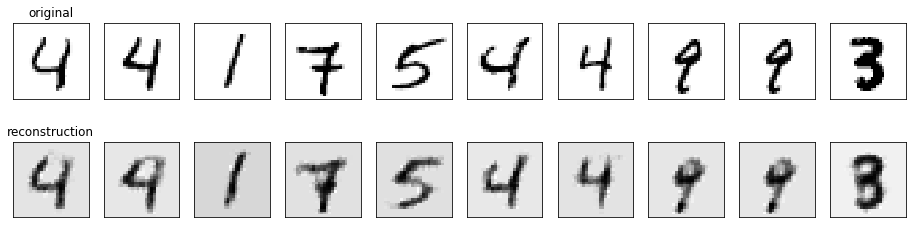

In [25]:
n_samples = 10
idx = np.random.choice(batch_size, n_samples)
_, axarr = plt.subplots(2, n_samples, figsize=(16,4))
for i,j in enumerate(idx):
    axarr[0,i].imshow(original[j].reshape((28,28)), cmap='Greys')
    if i==0:
        axarr[0,i].set_title('original')
    #axarr[0,i].axis('off')
    axarr[0,i].get_xaxis().set_ticks([])
    axarr[0,i].get_yaxis().set_ticks([])

    axarr[1,i].imshow(result[j].reshape((28,28)), cmap='Greys')
    if i==0:
        axarr[1,i].set_title('reconstruction')
    #axarr[1,i].axis('off')
    axarr[1,i].get_xaxis().set_ticks([])
    axarr[1,i].get_yaxis().set_ticks([])
plt.show()

#### Sample random images from the latent space

In [26]:
n_samples = 10
zsamples = nd.array(np.random.randn(n_samples*n_samples,8,2,2))
print(zsamples.shape)

(100, 8, 2, 2)


In [27]:
images = conv_net2.decoder(zsamples.as_in_context(model_ctx)).asnumpy()

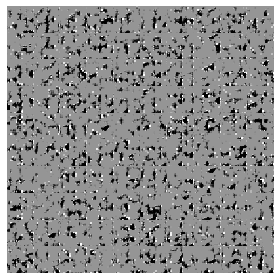

In [28]:
canvas = np.empty((28*n_samples, 28*n_samples))
for i, img in enumerate(images):
    x = i // n_samples
    y = i % n_samples
    canvas[(n_samples-y-1)*28:(n_samples-y)*28, x*28:(x+1)*28] = img.reshape(28, 28)
plt.figure(figsize=(4, 4))
plt.imshow(canvas, origin="upper", cmap="Greys")
plt.axis('off')
plt.tight_layout()